# Assignment 5

In this assignment, you will extend your work on the MNIST dataset by applying a Support Vector Machine (SVM) classifier. Your task is to fine-tune the SVM for hyperparameter optimization and compare its performance with the KNN and other classifiers from Assignment 4 (e.g., SGD, Random Forest). You will analyze the results to determine which classifier performs best on the MNIST dataset.

Assignment Instructions:

- Train an SVM Classifier on the MNIST Dataset

- Use Grid/Random Search with Cross-Validation to find the best hyperparameter values for the SVM classifier.
  - For the Polynomial Kernel, optimize the degree, C, and coef0 hyperparameters.
  - For the RBF Kernel, focus on optimizing C and gamma.
  - Compare the performance of the SVM with different kernels (Linear, Polynomial, and RBF) and select the best one based on test set accuracy and other metrics like precision, recall, and F1-score.
- Compare the SVM classifier’s performance with your classifiers from Assignment 4, i.e KNN, SGD, and Random Forest. Pay attention to accuracy, precision, recall, and other evaluation metrics. Also, include training time (computational complexity) as evaluation metric.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import util as utl

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

util loaded


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_scores(model, X, y, w='weighted'):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print('Accuracy: ', acc)
    print('Precision: ', precision_score(y, y_pred, average=w))
    print('Recall: ', recall_score(y, y_pred, average=w))
    print('F1: ', f1_score(y, y_pred, average=w))

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [6]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [7]:
X_train_scaled[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.41807788e-03, -5.75482007e-03, -4.08251677e-03, -4.08251723e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.08251677e-03, -4.70968802e-03, -8.79934616e-03, -1.15905590e-02,
       -1.47589790e-02, -1.92848537e-02, -2.46717967e-02, -2.90710256e-02,
       -3.05926595e-02, -3.11640110e-02, -3.19628716e-02, -3.02025359e-02,
       -3.13102193e-02, -2.83833966e-02, -2.31191907e-02, -1.91666260e-02,
       -1.67723000e-02, -1.09963603e-02, -8.32486060e-03, -4.38069366e-03,
        0.00000000e+00,  

# LinearSVC

Use LinearSVC instead of SVC(kernel='linear') for faster training time

In [8]:
# from sklearn.svm import LinearSVC

# pip_lin_clf = Pipeline([
#     ('scaler', StandardScaler()),
#     ('linear_svc', LinearSVC(loss='hinge', random_state=42))
# ])

# pip_lin_clf.fit(X_train, y_train)

In [9]:
# from sklearn.svm import LinearSVC

# lin_clf = LinearSVC(random_state=42)

# lin_clf.fit(X_train_scaled, y_train)

In [10]:
# utl.save_model(lin_clf, 'base_lin_clf')

lin_clf = utl.load_model('base_lin_clf')

In [11]:
print_scores(lin_clf, X_train_scaled, y_train)

Accuracy:  0.9275333333333333
Precision:  0.9271813560712039
Recall:  0.9275333333333333
F1:  0.927294427047738


## Hyper Tune

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param = {
    # 'max_iter': [int(x) for x in np.linspace(start=1000, stop=30000, num=10)],
    'C': [0.01, 0.1, 1, 10, 20, 30, 100],
    # 'loss': ['squared_hinge', 'hinge'],
    'tol': [1e-4, 1e-5, 1e-3]
}

random_search = RandomizedSearchCV(lin_clf, param_distributions=param, cv=3, n_iter=10, verbose=2, scoring='accuracy', return_train_score=True)

set_size = 1000

random_search.fit(X_train_scaled[:set_size], y_train[:set_size])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...................................C=10, tol=0.0001; total time=   0.8s
[CV] END ...................................C=10, tol=0.0001; total time=   0.7s
[CV] END ...................................C=10, tol=0.0001; total time=   0.6s
[CV] END ...................................C=20, tol=0.0001; total time=   0.9s
[CV] END ...................................C=20, tol=0.0001; total time=   0.7s
[CV] END ...................................C=20, tol=0.0001; total time=   0.6s
[CV] END ...................................C=30, tol=0.0001; total time=   0.9s
[CV] END ...................................C=30, tol=0.0001; total time=   0.8s
[CV] END ...................................C=30, tol=0.0001; total time=   0.7s
[CV] END ....................................C=1, tol=0.0001; total time=   0.7s
[CV] END ....................................C=1, tol=0.0001; total time=   0.7s
[CV] END ....................................C=1

/home/vinh/hv/iai600/assignments/5/repo/dev/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, tol=0.0001; total time=   0.9s
[CV] END ..................................C=100, tol=0.0001; total time=   0.9s
[CV] END ..................................C=100, tol=0.0001; total time=   0.7s
[CV] END ..................................C=0.01, tol=0.001; total time=   0.4s
[CV] END ..................................C=0.01, tol=0.001; total time=   0.3s
[CV] END ..................................C=0.01, tol=0.001; total time=   0.3s


/home/vinh/hv/iai600/assignments/5/repo/dev/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....................................C=20, tol=1e-05; total time=   1.3s
[CV] END ....................................C=20, tol=1e-05; total time=   1.1s
[CV] END ....................................C=20, tol=1e-05; total time=   0.9s
[CV] END .....................................C=1, tol=0.001; total time=   0.6s
[CV] END .....................................C=1, tol=0.001; total time=   0.7s
[CV] END .....................................C=1, tol=0.001; total time=   0.5s
[CV] END .................................C=0.01, tol=0.0001; total time=   0.4s
[CV] END .................................C=0.01, tol=0.0001; total time=   0.4s
[CV] END .................................C=0.01, tol=0.0001; total time=   0.4s


,estimator,LinearSVC(random_state=42)
,param_distributions,"{'C': [0.01, 0.1, ...], 'tol': [0.0001, 1e-05, ...]}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [18]:
utl.save_model(random_search, 'hyper_lin_clf')

linear_svc = utl.load_model('hyper_lin_clf')

In [19]:
linear_svc.best_params_

{'tol': 0.001, 'C': 0.01}

In [20]:
linear_svc.best_score_

np.float64(0.7740105374835914)

In [21]:
print_scores(linear_svc.best_estimator_, X_train_scaled, y_train)

Accuracy:  0.8083166666666667
Precision:  0.8081297880018218
Recall:  0.8083166666666667
F1:  0.806450774999586


In [22]:
linear_svc.best_estimator_.fit(X_train_scaled, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.001
,C,0.01
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


In [23]:
print_scores(linear_svc.best_estimator_, X_train_scaled, y_train)

Accuracy:  0.9245
Precision:  0.9241188002095425
Recall:  0.9245
F1:  0.9241913292031022


# SVC RBF

In [18]:
# from sklearn.svm import SVC

# svm_clf = SVC(kernel='rbf', gamma='scale')

# svm_clf.fit(X_train_scaled, y_train)

In [19]:
# utl.save_model(svm_clf, 'svc_rbf')

svm_clf = utl.load_model('svc_rbf')

In [20]:
# y_pred = svm_clf.predict(X_train_scaled)
# accuracy_score(y_train, y_pred)

## Hyper tune

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {
    "gamma": reciprocal(0.001, 0.1),
    "C": uniform(1, 10)
}

rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=4.745401188473625, gamma=0.07969454818643935; total time=   0.2s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643935; total time=   0.2s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643935; total time=   0.2s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779727; total time=   0.2s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779727; total time=   0.2s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779727; total time=   0.2s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=   0.1s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=   0.1s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=   0.1s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787434; total time=   0.2s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787434; total time=   0.2s
[CV] END ....C=1.5808361216819946, gamma=0.05399

,estimator,SVC()
,param_distributions,"{'C': <scipy.stats....x7a0599f05dc0>, 'gamma': <scipy.stats....x7a0598fa2c60>}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [22]:
rnd_search_cv.best_params_

{'C': np.float64(2.560186404424365), 'gamma': np.float64(0.002051110418843397)}

In [23]:
rnd_search_cv.best_score_

np.float64(0.8519837202471933)

In [24]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

,C,np.float64(2.560186404424365)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0....1110418843397)
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [34]:
# utl.save_model(rnd_search_cv, 'svc_rbf_hyper')

rnd_search_cv = utl.load_model('svc_rbf_hyper')

In [26]:
print_scores(rnd_search_cv.best_estimator_, X_train_scaled, y_train)

Accuracy:  0.9973666666666666
Precision:  0.997367571384179
Recall:  0.9973666666666666
F1:  0.997366529565483


# SVC Poly

In [27]:
# from sklearn.svm import SVC

# svc_poly = SVC(kernel='poly')

# svc_poly.fit(X_train_scaled, y_train)

In [28]:
# utl.save_model(svc_poly, 'svc_poly')

svc_poly = utl.load_model('svc_poly')

In [29]:
print_scores(svc_poly, X_train_scaled, y_train)

Accuracy:  0.9776666666666667
Precision:  0.9781476481540945
Recall:  0.9776666666666667
F1:  0.9777560691451375


## Hyper tune

In [30]:
from scipy.stats import reciprocal, uniform

# param_distributions = {
#     "coef0": reciprocal(0.001, 0.1),
#     "C": uniform(1, 10),
#     "degree": [1, 3, 6],
# }

param_distributions = {
    "coef0": [1, 1.5, 2.5],
    "C": [1, 5, 10],
    "degree": [1, 3, 6],
}

rnd_search_poly= RandomizedSearchCV(svc_poly, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_poly.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...........................C=5, coef0=2.5, degree=6; total time=   0.1s
[CV] END ...........................C=5, coef0=2.5, degree=6; total time=   0.1s
[CV] END ...........................C=5, coef0=2.5, degree=6; total time=   0.1s
[CV] END ..........................C=10, coef0=1.5, degree=3; total time=   0.1s
[CV] END ..........................C=10, coef0=1.5, degree=3; total time=   0.1s
[CV] END ..........................C=10, coef0=1.5, degree=3; total time=   0.1s
[CV] END ..........................C=10, coef0=2.5, degree=1; total time=   0.1s
[CV] END ..........................C=10, coef0=2.5, degree=1; total time=   0.1s
[CV] END ..........................C=10, coef0=2.5, degree=1; total time=   0.1s
[CV] END ...........................C=5, coef0=2.5, degree=3; total time=   0.1s
[CV] END ...........................C=5, coef0=2.5, degree=3; total time=   0.1s
[CV] END ...........................C=5, coef0=2

,estimator,SVC(kernel='poly')
,param_distributions,"{'C': [1, 5, ...], 'coef0': [1, 1.5, ...], 'degree': [1, 3, ...]}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [31]:
rnd_search_poly.best_params_

{'degree': 3, 'coef0': 1.5, 'C': 10}

In [32]:
rnd_search_poly.best_estimator_.fit(X_train_scaled, y_train)

,C,10
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,1.5
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [33]:
print_scores(rnd_search_poly.best_estimator_, X_train_scaled, y_train)

Accuracy:  0.9999833333333333
Precision:  0.9999833361344538
Recall:  0.9999833333333333
F1:  0.9999833333203851


In [39]:
# utl.save_model(rnd_search_poly, 'rnd_search_poly')

rnd_search_poly = utl.load_model('rnd_search_poly')

# Test set Showdown

In [28]:
print_scores(linear_svc.best_estimator_, X_test_scaled, y_test)

Accuracy:  0.9153
Precision:  0.9149357830608335
Recall:  0.9153
F1:  0.9149130153584997


In [36]:
print_scores(rnd_search_cv.best_estimator_, X_test_scaled, y_test)

Accuracy:  0.9708
Precision:  0.9712845764388353
Recall:  0.9708
F1:  0.9708825917186701


In [47]:
print_scores(rnd_search_poly.best_estimator_, X_test_scaled, y_test)

Accuracy:  0.9753
Precision:  0.9753009936989345
Recall:  0.9753
F1:  0.9752835431617466


# Performance evaluations

## Learning Curves

In [26]:
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay

def draw_learning_curve(model, X, y, title):
    common_params = {
        "X": X,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
        "score_type": "both",
        "score_name": "Accuracy",
        "line_kw": {"marker": "o"},
        "std_display_style": 'fill_between',
    }
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.subplots_adjust(hspace=0.5)

    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Train Score", "Test Score"])
    ax.set_title(title)
    ax.set_xlabel("Set size")
    ax.grid(True)

    save_fig("LC_"+title)

Saving figure LC_SVC (kernel=linear) on Test Set


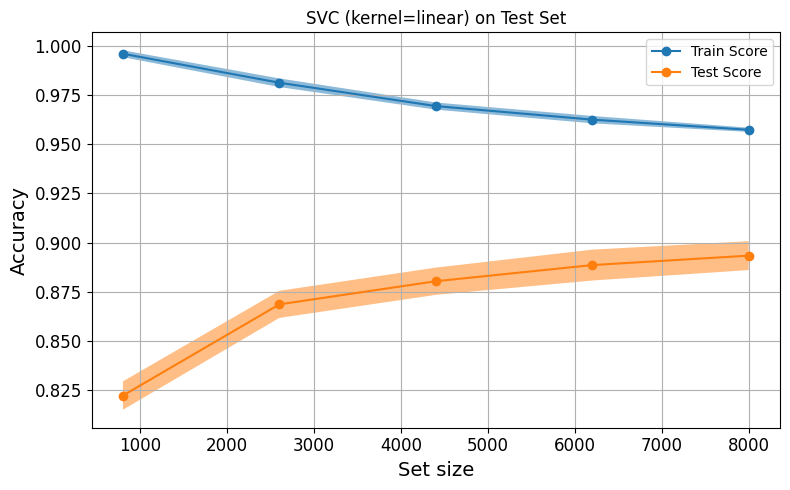

In [27]:
draw_learning_curve(linear_svc.best_estimator_, X_test_scaled, y_test, 'SVC (kernel=linear) on Test Set')

Saving figure LC_SVC (kernel=RBF) on Test Set


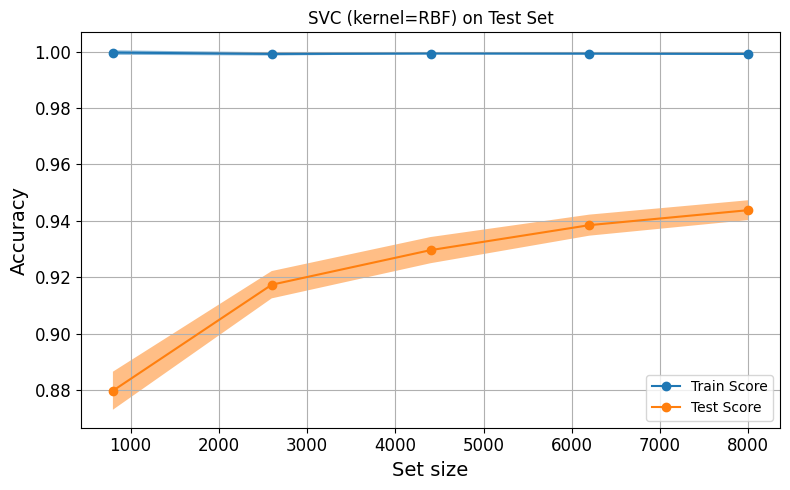

In [40]:
draw_learning_curve(rnd_search_cv.best_estimator_, X_test_scaled, y_test, 'SVC (kernel=RBF) on Test Set')

Saving figure LC_SVC (kernel=poly) on Test Set


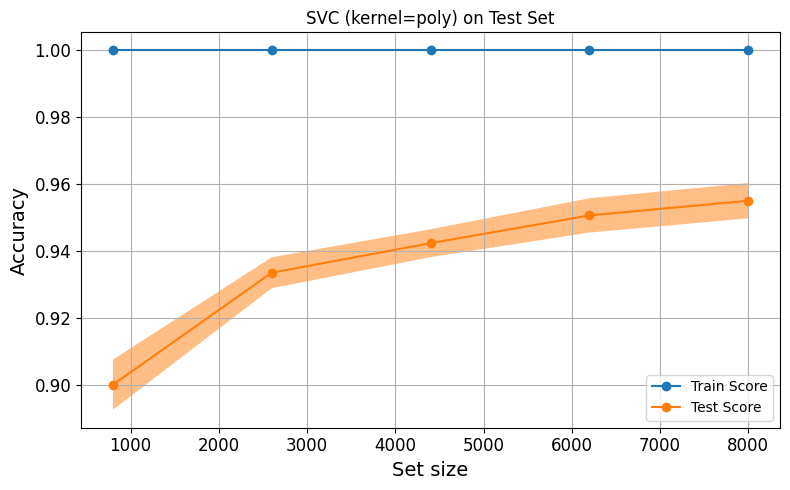

In [41]:
draw_learning_curve(rnd_search_poly.best_estimator_, X_test_scaled, y_test, 'SVC (kernel=poly) on Test Set')

## Complexity Analysis

### Linear

In [29]:
from sklearn.model_selection import learning_curve

common_params = {
    "X": X_test_scaled,
    "y": y_test,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_nb, fit_times_nb, score_times_nb = learning_curve(
    linear_svc.best_estimator_, **common_params
)

Saving figure scalability_svc_linear


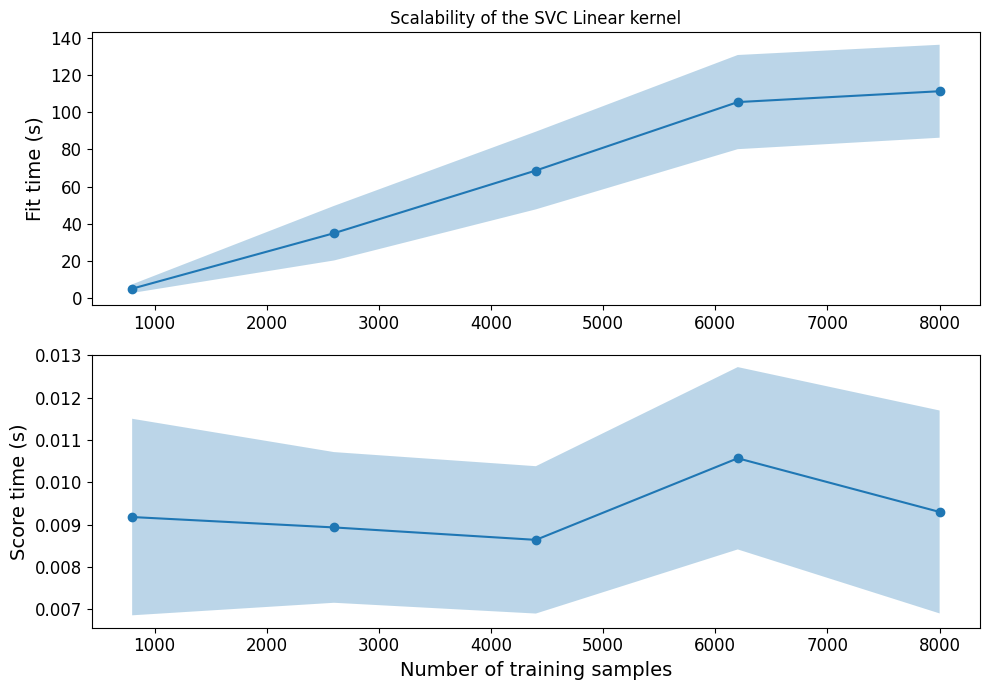

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
ax[0].plot(train_sizes, fit_times_nb.mean(axis=1), "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_nb.mean(axis=1) - fit_times_nb.std(axis=1),
    fit_times_nb.mean(axis=1) + fit_times_nb.std(axis=1),
    alpha=0.3
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the SVC Linear kernel")

ax[1].plot(train_sizes, score_times_nb.mean(axis=1), "o-")
ax[1].fill_between(
    train_sizes,
    score_times_nb.mean(axis=1) - score_times_nb.std(axis=1),
    score_times_nb.mean(axis=1) + score_times_nb.std(axis=1),
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

save_fig('scalability_svc_linear')

### RBF

In [43]:
from sklearn.model_selection import learning_curve

common_params = {
    "X": X_test_scaled,
    "y": y_test,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_rbf, fit_times_rbf, score_times_rbf = learning_curve(
    rnd_search_cv.best_estimator_, **common_params
)

Saving figure scalability_svc_rbf


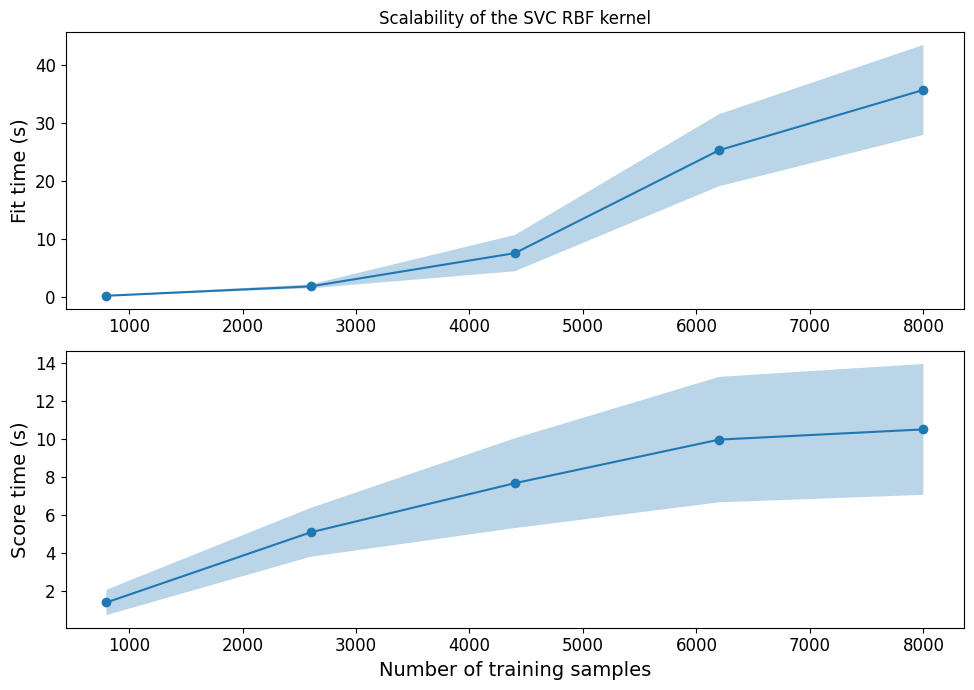

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
ax[0].plot(train_sizes, fit_times_rbf.mean(axis=1), "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_rbf.mean(axis=1) - fit_times_rbf.std(axis=1),
    fit_times_rbf.mean(axis=1) + fit_times_rbf.std(axis=1),
    alpha=0.3
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the SVC RBF kernel")

ax[1].plot(train_sizes, score_times_rbf.mean(axis=1), "o-")
ax[1].fill_between(
    train_sizes,
    score_times_rbf.mean(axis=1) - score_times_rbf.std(axis=1),
    score_times_rbf.mean(axis=1) + score_times_rbf.std(axis=1),
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

save_fig('scalability_svc_rbf')

### Poly

In [45]:
from sklearn.model_selection import learning_curve

common_params = {
    "X": X_test_scaled,
    "y": y_test,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_poly, fit_times_poly, score_times_poly = learning_curve(
    rnd_search_poly.best_estimator_, **common_params
)

Saving figure scalability_svc_poly


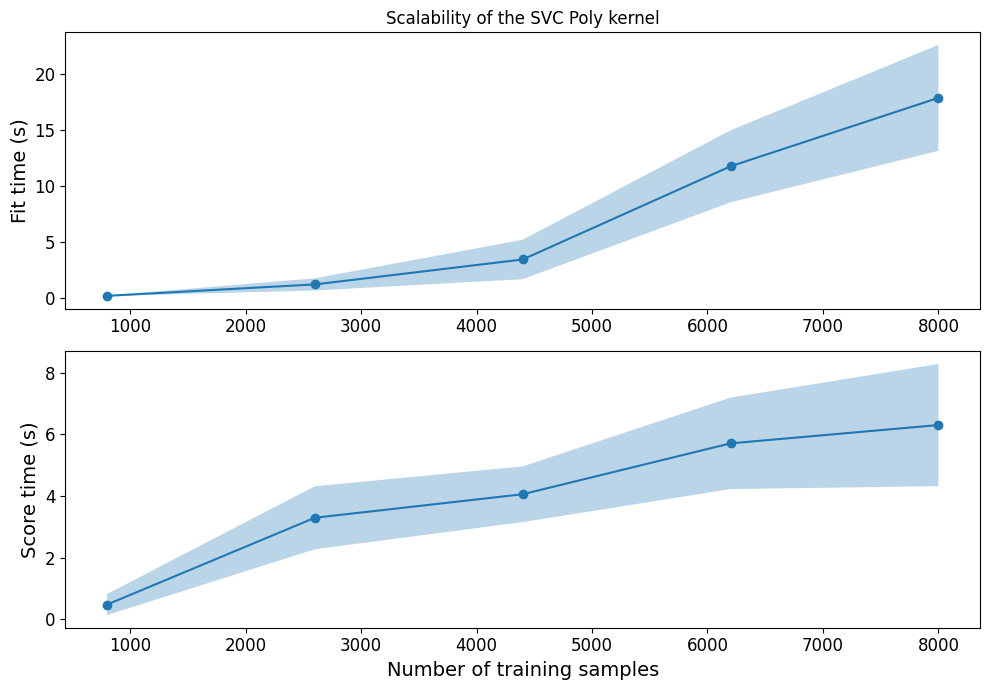

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
ax[0].plot(train_sizes, fit_times_poly.mean(axis=1), "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_poly.mean(axis=1) - fit_times_poly.std(axis=1),
    fit_times_poly.mean(axis=1) + fit_times_poly.std(axis=1),
    alpha=0.3
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the SVC Poly kernel")

ax[1].plot(train_sizes, score_times_poly.mean(axis=1), "o-")
ax[1].fill_between(
    train_sizes,
    score_times_poly.mean(axis=1) - score_times_poly.std(axis=1),
    score_times_poly.mean(axis=1) + score_times_poly.std(axis=1),
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

save_fig('scalability_svc_poly')